In [1]:
import torch
import torchvision
from torch import nn, optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import pandas as pd
import json
import matplotlib.pyplot as plt
import cv2

In [2]:
transform = transforms.Compose([
#     transforms.CenterCrop(178),  # Crop the center of the image
#     transforms.Resize((64, 64)),  # Resize the image to (64, 64)
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
])

In [3]:
train_dataset = torchvision.datasets.WIDERFace('./data', split ='train', download=False)

In [4]:
train_dataset[140]

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x668 at 0x1280E840880>,
 {'bbox': tensor([[164,  84,  62,  80],
          [346,  72,  58,  94],
          [464,  94,  70,  78],
          [634, 110,  66,  64],
          [780, 106,  64,  84]]),
  'blur': tensor([0, 0, 0, 0, 0]),
  'expression': tensor([0, 0, 0, 0, 0]),
  'illumination': tensor([0, 0, 0, 0, 0]),
  'occlusion': tensor([0, 0, 0, 0, 0]),
  'pose': tensor([0, 0, 0, 0, 0]),
  'invalid': tensor([0, 0, 0, 0, 0])})

<font size='5'> ImageId to wiadomo, a personId to Id osoby na zdjęciu po kolei tak, jak bounding boxy pokazują. Czyli bierzemy image=imageId i bounding box odpowiadający personId</font>

In [17]:
face1 = train_dataset[140][1]['bbox'][0]
x, y, width, height = face1.split(1)
x = int(x)
y = int(y)
width = int(width)
height = int(height)

In [18]:
x, y, width, height

(164, 84, 62, 80)

In [20]:
image = train_dataset[140][0]

In [24]:
plt.imshow(image[0][:,:,::-1])
plt.title('Cropped Image')

plt.show()

IndexError: too many indices for tensor of dimension 2

In [21]:
cropped_image = image.crop((x, y, x + width, y + height))

AttributeError: 'Tensor' object has no attribute 'crop'

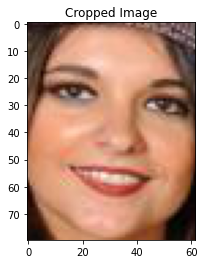

In [29]:
plt.imshow(cropped_image)
plt.title('Cropped Image')

plt.show()

In [30]:
cropped_image.save('cropped_faces/cropped_image.jpg')

In [54]:
def cropFacesFromWiderFace(widerfaceDataset=train_dataset, face_attrs=face_attrs):
    for index,elem in enumerate(face_attrs):
        image = widerfaceDataset[elem['imageId']][0] # nr zdjecia
        face = widerfaceDataset[elem['imageId']][1]['bbox'][elem['personId']] # nr twarzy
        x, y, width, height = face.split(1)
        x = int(x)
        y = int(y)
        width = int(width)
        height = int(height)
        cropped_image = image.crop((x, y, x + width, y + height))
        imgId = elem['imageId']
        pId = elem['personId']
        cropped_image.save(f'cropped_faces2/{imgId}_{pId}.jpg')

In [56]:
cropFacesFromWiderFace()

In [4]:
import os
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [35]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # ten sort jest robiony po to, żeby zdjęcia ładowały się po kolei tak jak są w jsonie
        self.image_paths = [os.path.join(root_dir, img) for img in sorted(os.listdir(root_dir), key=lambda x: (int(x.split('_')[0]), int(x.split('_')[1][:-4])))] # [:-4] zeby usunac .jpg

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image

In [36]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [37]:
dataset = CustomDataset(root_dir='cropped_faces', transform=transform)

In [38]:
print(dataset[0]) # odpowiada pierwszemu elementowi w face_attrs.json

tensor([[[0.1529, 0.1804, 0.2039,  ..., 0.3686, 0.4510, 0.4471],
         [0.1529, 0.1804, 0.2000,  ..., 0.3686, 0.4667, 0.4235],
         [0.2157, 0.2118, 0.2039,  ..., 0.4510, 0.4980, 0.4275],
         ...,
         [0.0745, 0.0706, 0.0824,  ..., 0.1843, 0.2000, 0.1686],
         [0.0627, 0.0549, 0.0627,  ..., 0.2235, 0.2196, 0.1569],
         [0.0510, 0.0431, 0.0510,  ..., 0.2549, 0.2314, 0.1490]],

        [[0.0588, 0.0902, 0.1216,  ..., 0.2980, 0.3882, 0.3882],
         [0.0667, 0.0941, 0.1216,  ..., 0.2980, 0.3961, 0.3647],
         [0.1333, 0.1294, 0.1294,  ..., 0.3765, 0.4275, 0.3608],
         ...,
         [0.0745, 0.0588, 0.0588,  ..., 0.1020, 0.1216, 0.0941],
         [0.0784, 0.0627, 0.0549,  ..., 0.1255, 0.1333, 0.0863],
         [0.0824, 0.0588, 0.0471,  ..., 0.1529, 0.1373, 0.0824]],

        [[0.0784, 0.1098, 0.1373,  ..., 0.2980, 0.3765, 0.3686],
         [0.0784, 0.1020, 0.1255,  ..., 0.2980, 0.3882, 0.3451],
         [0.1333, 0.1294, 0.1294,  ..., 0.3804, 0.4275, 0.

In [41]:
with open('face_attrs.json', 'r') as json_file:
    face_attrs = json.load(json_file)

In [42]:
face_attrs[0]

{'imageId': 140, 'personId': 0, 'isMale': False, 'glasses': False}

In [43]:
# zamiana false i true na 0 i 1 bo niepotrzebnie zapisane jako bool
for i in range(len(face_attrs)):
    if face_attrs[i]['isMale']:
        face_attrs[i]['isMale'] = 1
    else:
        face_attrs[i]['isMale'] = 0

In [44]:
widerface = list(dataset)

In [45]:
for i in range(len(widerface)):
    imageId = face_attrs[i]['imageId']
    personId = face_attrs[i]['personId']
    isMale = face_attrs[i]['isMale']
    widerface[i] = (widerface[i], (imageId, personId, isMale))

In [46]:
widerface[0]

(tensor([[[0.1529, 0.1804, 0.2039,  ..., 0.3686, 0.4510, 0.4471],
          [0.1529, 0.1804, 0.2000,  ..., 0.3686, 0.4667, 0.4235],
          [0.2157, 0.2118, 0.2039,  ..., 0.4510, 0.4980, 0.4275],
          ...,
          [0.0745, 0.0706, 0.0824,  ..., 0.1843, 0.2000, 0.1686],
          [0.0627, 0.0549, 0.0627,  ..., 0.2235, 0.2196, 0.1569],
          [0.0510, 0.0431, 0.0510,  ..., 0.2549, 0.2314, 0.1490]],
 
         [[0.0588, 0.0902, 0.1216,  ..., 0.2980, 0.3882, 0.3882],
          [0.0667, 0.0941, 0.1216,  ..., 0.2980, 0.3961, 0.3647],
          [0.1333, 0.1294, 0.1294,  ..., 0.3765, 0.4275, 0.3608],
          ...,
          [0.0745, 0.0588, 0.0588,  ..., 0.1020, 0.1216, 0.0941],
          [0.0784, 0.0627, 0.0549,  ..., 0.1255, 0.1333, 0.0863],
          [0.0824, 0.0588, 0.0471,  ..., 0.1529, 0.1373, 0.0824]],
 
         [[0.0784, 0.1098, 0.1373,  ..., 0.2980, 0.3765, 0.3686],
          [0.0784, 0.1020, 0.1255,  ..., 0.2980, 0.3882, 0.3451],
          [0.1333, 0.1294, 0.1294,  ...,

(148, 0, 0)


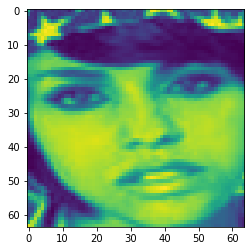

In [47]:
plt.imshow(widerface[5][0][0])
print(widerface[5][1])
plt.show()

In [48]:
test_loader = torch.utils.data.DataLoader(widerface, batch_size=64)

In [49]:
class CNN(torch.nn.Module):
    def __init__(self, activationCNN, activationOut):
        super(CNN, self).__init__()
        torch.manual_seed(42)
        
        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.linear = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = self.convolutional(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return torch.softmax(x, 1)

In [50]:
model = torch.load('celeba_custom_model_is_male.pth', map_location=torch.device('cpu'))

In [51]:
model.eval()

CNN(
  (convolutional): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (linear): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    

In [52]:
correct_indexes = []
bad_indexes = []

In [53]:
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for idx in range(len(preds)):
            if labels[2][idx] == preds[idx]: # na drugim indexie jest wartość cechy isMale
                correct_indexes.append((labels[0][idx], labels[1][idx])) # dodajemy do listy tuple postaci (imageId, personId)
            else:
                bad_indexes.append((inputs[idx], labels[0][idx], labels[1][idx], preds[idx]))

In [54]:
print('Accuracy:')
print(len(correct_indexes)/len(widerface))
print(len(bad_indexes)/len(widerface))

Accuracy:
0.6190476190476191
0.38095238095238093


In [55]:
should_be_male_is_female = 0
should_be_female_is_male = 0
for elem in bad_indexes:
    if elem[3] == 1:
        should_be_female_is_male += 1
    else:
        should_be_male_is_female += 1

print(should_be_female_is_male)
print(should_be_male_is_female)

109
35


(tensor([[[0.7765, 0.7804, 0.8078,  ..., 0.7529, 0.7529, 0.7569],
         [0.7882, 0.7961, 0.8196,  ..., 0.7529, 0.7529, 0.7569],
         [0.7961, 0.8118, 0.8275,  ..., 0.7529, 0.7569, 0.7608],
         ...,
         [0.9294, 0.9137, 0.8902,  ..., 0.9373, 0.9608, 0.9216],
         [0.9294, 0.9255, 0.8980,  ..., 0.9412, 0.9608, 0.9137],
         [0.9373, 0.9216, 0.9098,  ..., 0.9412, 0.9608, 0.9020]],

        [[0.6667, 0.6706, 0.6902,  ..., 0.6510, 0.6510, 0.6549],
         [0.6824, 0.6863, 0.7020,  ..., 0.6510, 0.6510, 0.6549],
         [0.6980, 0.7059, 0.7176,  ..., 0.6510, 0.6549, 0.6588],
         ...,
         [0.7882, 0.7725, 0.7412,  ..., 0.8039, 0.8275, 0.7882],
         [0.7843, 0.7843, 0.7490,  ..., 0.8078, 0.8275, 0.7804],
         [0.7922, 0.7804, 0.7647,  ..., 0.8078, 0.8275, 0.7686]],

        [[0.5098, 0.5059, 0.5255,  ..., 0.5137, 0.5137, 0.5176],
         [0.5255, 0.5294, 0.5412,  ..., 0.5137, 0.5137, 0.5176],
         [0.5451, 0.5529, 0.5569,  ..., 0.5216, 0.5176, 0

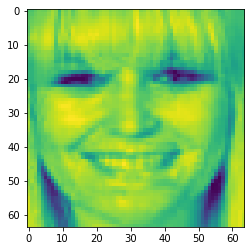

In [56]:
plt.imshow(bad_indexes[0][0][0])
print(bad_indexes[0])
plt.show()

(tensor([[[0.1882, 0.1647, 0.1529,  ..., 0.1490, 0.1529, 0.1529],
         [0.1686, 0.1569, 0.1647,  ..., 0.1412, 0.1529, 0.1529],
         [0.1412, 0.1490, 0.1765,  ..., 0.1451, 0.1451, 0.1451],
         ...,
         [0.0941, 0.1020, 0.1333,  ..., 0.3098, 0.2784, 0.2667],
         [0.1333, 0.1412, 0.1608,  ..., 0.3098, 0.2784, 0.2706],
         [0.1216, 0.1373, 0.1569,  ..., 0.3294, 0.2784, 0.2706]],

        [[0.1686, 0.1451, 0.1373,  ..., 0.0902, 0.0980, 0.0980],
         [0.1490, 0.1412, 0.1490,  ..., 0.0824, 0.0980, 0.0980],
         [0.1255, 0.1333, 0.1608,  ..., 0.0863, 0.0902, 0.0902],
         ...,
         [0.0588, 0.0667, 0.0980,  ..., 0.1961, 0.2039, 0.1961],
         [0.0980, 0.1059, 0.1255,  ..., 0.1961, 0.2039, 0.2000],
         [0.0863, 0.1020, 0.1216,  ..., 0.2157, 0.2039, 0.2000]],

        [[0.1843, 0.1569, 0.1412,  ..., 0.0784, 0.0863, 0.0863],
         [0.1608, 0.1451, 0.1490,  ..., 0.0706, 0.0863, 0.0863],
         [0.1216, 0.1255, 0.1490,  ..., 0.0745, 0.0784, 0

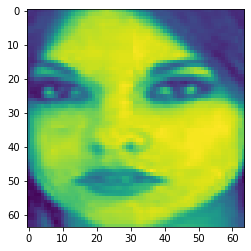

In [57]:
plt.imshow(bad_indexes[1][0][0])
print(bad_indexes[1])
plt.show()

(tensor([[[0.9569, 0.9412, 0.9373,  ..., 0.8706, 0.8431, 0.8118],
         [0.9451, 0.9255, 0.9176,  ..., 0.8706, 0.8667, 0.8353],
         [0.9255, 0.9020, 0.8941,  ..., 0.8196, 0.8510, 0.8627],
         ...,
         [0.9255, 0.9098, 0.9255,  ..., 0.6353, 0.6784, 0.7176],
         [0.9059, 0.9059, 0.9333,  ..., 0.6784, 0.7176, 0.7373],
         [0.9059, 0.9059, 0.9373,  ..., 0.7098, 0.7294, 0.7333]],

        [[0.9608, 0.9412, 0.9255,  ..., 0.8196, 0.7961, 0.7608],
         [0.9412, 0.9216, 0.9020,  ..., 0.8196, 0.8118, 0.7804],
         [0.9137, 0.8902, 0.8706,  ..., 0.7647, 0.7961, 0.8078],
         ...,
         [0.8706, 0.8588, 0.8784,  ..., 0.5294, 0.5843, 0.6353],
         [0.8549, 0.8627, 0.8941,  ..., 0.5647, 0.6196, 0.6471],
         [0.8627, 0.8706, 0.9059,  ..., 0.5922, 0.6314, 0.6392]],

        [[0.9412, 0.9216, 0.9098,  ..., 0.7686, 0.7412, 0.7059],
         [0.9255, 0.9020, 0.8863,  ..., 0.7686, 0.7608, 0.7294],
         [0.8902, 0.8667, 0.8510,  ..., 0.7137, 0.7412, 0

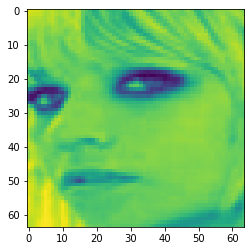

In [58]:
plt.imshow(bad_indexes[2][0][0])
print(bad_indexes[2])
plt.show()

(tensor([[[0.6353, 0.5529, 0.4510,  ..., 0.1059, 0.1255, 0.1529],
         [0.5686, 0.4392, 0.3255,  ..., 0.1020, 0.1098, 0.1294],
         [0.3765, 0.2745, 0.2078,  ..., 0.1020, 0.0980, 0.1059],
         ...,
         [0.9020, 0.8824, 0.8510,  ..., 0.1216, 0.0980, 0.0824],
         [0.5647, 0.5686, 0.5490,  ..., 0.0941, 0.0863, 0.0824],
         [0.5216, 0.5176, 0.5608,  ..., 0.0706, 0.0706, 0.0627]],

        [[0.5373, 0.4549, 0.3608,  ..., 0.0706, 0.0863, 0.1137],
         [0.4784, 0.3529, 0.2392,  ..., 0.0667, 0.0706, 0.0902],
         [0.3098, 0.2039, 0.1333,  ..., 0.0706, 0.0667, 0.0706],
         ...,
         [0.8431, 0.8196, 0.7843,  ..., 0.0627, 0.0392, 0.0235],
         [0.4980, 0.5020, 0.4745,  ..., 0.0471, 0.0353, 0.0314],
         [0.4706, 0.4627, 0.4941,  ..., 0.0353, 0.0392, 0.0314]],

        [[0.4863, 0.4039, 0.3059,  ..., 0.0627, 0.0784, 0.1059],
         [0.4314, 0.3020, 0.1843,  ..., 0.0588, 0.0627, 0.0824],
         [0.2549, 0.1490, 0.0784,  ..., 0.0588, 0.0549, 0

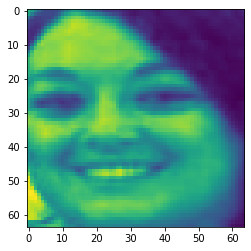

In [59]:
plt.imshow(bad_indexes[3][0][0])
print(bad_indexes[3])
plt.show()